In [1]:
import jax
import jax.numpy as jnp
import chex

from typing import NamedTuple

from experior.utils import PRNGSequence, moving_average
import matplotlib.pyplot as plt

jax.config.update("jax_debug_nans", True)

%load_ext autoreload
%autoreload 2


## ISSUES
1. Diverging when optimizing both lambda and alpha
2. Estimating the expert distribution is not efficient (expert_mc_samples)
3. The value of beta is different between the generated samples and the likelihood estimation
4. How to show the derived prior makes sense? Is it close to the true prior in any sense? E.g., compared to the standard gaussian
5. Multi-armed bandit experiment

In [95]:
EPISODES = 2000
env_config = {"num_envs": 500, "num_actions": 10}
expert_config = {"n_trajectory": 1000, "horizon": 1}
ts_config = {
  "total_steps": EPISODES,
  "langevin_learning_rate": 0.01,
  "langevin_batch_size": 128,
  "langevin_updates_per_step": 10
}
max_ent_config = {
  "total_steps": EPISODES,
  "langevin_learning_rate": 0.01,
  "langevin_batch_size": 128,
  "langevin_updates_per_step": 10,
  "max_ent_epsilon": 1e-3,
  "max_ent_prior_n_samples": 1000,
  "max_ent_steps": 1000,
  "max_ent_learning_rate": 1e-3,
  "max_ent_lambda": 10.,
  "expert_beta": 1.,
  "init_emp_ent": 0.,
}

## Environments

In [97]:
from experior.envs import BayesStochasticBandit
from gymnax.environments import spaces

rng = PRNGSequence(42)
# multi-armed bandit environment
action_space = spaces.Discrete(env_config["num_actions"])
alpha_betas = jax.random.uniform(next(rng), shape=(env_config["num_actions"], 2)) * 10. + 1.
# prior_function = jax.tree_util.Partial(lambda key: jax.random.beta(key, alpha_betas[:, 0], alpha_betas[:, 1]))
prior_function = jax.tree_util.Partial(lambda key: jnp.arange(env_config["num_actions"], dtype=jnp.float32) / env_config["num_actions"])
reward_dist_fn = jax.tree_util.Partial(lambda key, means, _, action: jax.random.bernoulli(key, means[action]).astype(jnp.float32))
best_action_value_fn = jax.tree_util.Partial(lambda means, _: (means.argmax(), means.max()))
mutli_armed_bandit = BayesStochasticBandit(action_space, prior_function, reward_dist_fn, best_action_value_fn)

In [98]:
from experior.bandit_agents import LinearDiscreteRewardModel
feature_fn = jax.tree_util.Partial(lambda obs, action: jax.nn.one_hot(action, env_config["num_actions"]))
reward_model = LinearDiscreteRewardModel(n_actions=env_config["num_actions"],
                                         params_dim=env_config["num_actions"],
                                         feature_fn=feature_fn,
                                         dist="bernoulli")
prior_log_pdf = jax.tree_util.Partial(lambda params: jnp.zeros((1,)))

In [99]:
from experior.bandit_agents import make_thompson_sampling
ts_train = make_thompson_sampling(env=mutli_armed_bandit,
                                  reward_model=reward_model,
                                  prior_log_pdf=prior_log_pdf,
                                  num_envs = env_config["num_envs"],
                                  **ts_config)

In [100]:
state, no_prior_metrics = jax.jit(ts_train)(next(rng))

/h/vdblm/.jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


## Generate Expert Trajectories

In [101]:
from experior.experts import generate_optimal_trajectories
expert_trajectories = generate_optimal_trajectories(next(rng), mutli_armed_bandit, expert_config["n_trajectory"], horizon=1)

In [103]:
from experior.bandit_agents import make_max_ent_thompson_sampling
max_ent_ts_train = make_max_ent_thompson_sampling(mutli_armed_bandit,
                                          reward_model,
                                          num_envs=env_config["num_envs"],
                                          **max_ent_config)

In [104]:
state, max_ent_state, max_ent_metrics = jax.jit(max_ent_ts_train)(next(rng), expert_trajectories)

/h/vdblm/.jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


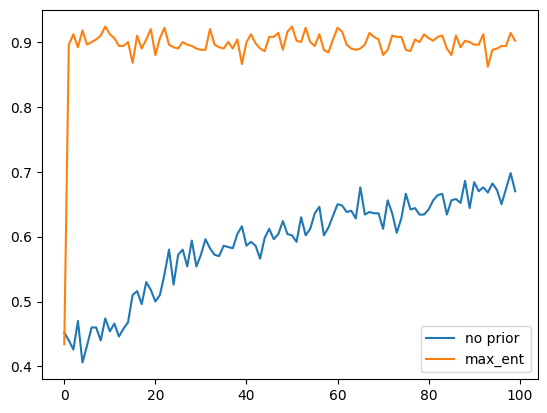

In [110]:
plt.plot(moving_average(no_prior_metrics["reward"].mean(axis=-1)[:100], 1), label="no prior")
plt.plot(moving_average(max_ent_metrics["reward"].mean(axis=-1)[:100], 1), label="max_ent")
# plt.plot(moving_average(true_out["metrics"].reward.mean(axis=0).reshape(-1,), 10), label="true prior")
plt.legend()
plt.show()
